In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
import re
import seaborn as sns

In [2]:
datasrc = "/net/store/nbp/projects/GTI_decoding/data/pilot"

triggers = ['CueTimeStamp',
                'CueDisappearedTimeStamp',
                'ObjectShownTimeStamp',
                'BeepPlayedTimeStamp',
                'ButtonPressedTimeStamp']
eeg = 'openvibeSignal'
stimulus = 'ToolCueOrientationString'

tools = ['daisygrubber', 'fishscaler', 'flowercutter', 'fork', 'paintbrush',
       'paletteknife', 'screwdriver', 'spatula', 'spokewrench', 'trowel',
       'wrench', 'zester']

familiar = ['fork','trowel','screwdriver','spatula','paintbrush','wrench']
tool_fam_map = {t:('fam' if t in familiar else 'unfam') for t in tools}

event_mapping = {'task': 1,
                 'inter-task-object': 2,
                 'object': 3,
                 'action': 4,
                 'inter-trial':5 }

pilots = [f for f in os.listdir(datasrc) if re.match(r'P[\d]+', f)]

In [3]:
def get_streams(dxdf):
    trig_streams = [99] * len(triggers)
    eeg_stream = 99
    stim_stream = 99 
    
    for i in range(len(data)):
        if data[i]["info"]['name'][0] == eeg:
            eeg_stream = i
        elif data[i]["info"]['name'][0] == stimulus:
            stim_stream = i
        else:
            try:
                trig_streams[triggers.index(data[i]["info"]['name'][0])] = i
            except:
                pass
    return eeg_stream, stim_stream, trig_streams


def get_stimulus_from_header(dxdf,block,idx):
    tmplst = []
    for i in range(len(dxdf[idx]["time_series"])):
        tmp = {}
        tmp['block'] = block
        tmp['tool'] = dxdf[idx]["time_series"][i][0]
        tmp['cue'] = dxdf[idx]["time_series"][i][2]
        tmp['ori'] = dxdf[idx]["time_series"][i][3]
        tmp['familiarity'] = tool_fam_map[dxdf[idx]["time_series"][i][0]]
        tmplst.append(tmp)
    return tmplst
        
def get_event_triggers(dxdf,block,eeg_stream,trig_streams,event_map): # Extract the triggers and concatenate them
    tmpdfs = []
    evntlist = {desc:idx for idx, desc in event_map.items()}
    for i, stim_idx in enumerate(trig_streams):
        tmpdf = pd.DataFrame(data[stim_idx]["time_stamps"],columns=[evntlist[i + 1]])
        tmpdfs.append(tmpdf)
    
    tmpdf = pd.concat(tmpdfs,axis=1)
    tmpdf['block'] = block
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    
    return tmpdf


def extract_stimulus(tmpdf):
    tmpdf['check_field'] = tmpdf.apply(lambda x: "/".join([x['cue'],x['tool'],x['ori']]),axis=1)
    tmpdf['intra_block'] = tmpdf['block'] == tmpdf['block'].shift()
    tmpdf['eq'] = tmpdf['check_field'] == tmpdf['check_field'].shift()
    selection_mask = ~tmpdf['eq'] | ~tmpdf['intra_block'] 
    tmpdf = tmpdf.loc[selection_mask,:].reset_index(drop=True)
    tmpdf.drop(columns=['eq','check_field','intra_block'],axis=1,inplace=True)
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    return tmpdf
    

In [4]:
def gather_one_subject_data(trial_df,event_df):
    x = event_df.reset_index().drop(columns=['index','trial_id'],axis=1).reset_index().rename(columns={'index':'trial_id'})
    y = trial_df.merge(x,on=['trial_id','block'])
    task_t = y['inter-task-object'] - y['task']
    inter_task_object_t = y['object'] - y['inter-task-object']
    object_t = y['action'] - y['object']
    action_t = y['inter-trial'] - y['action']
    inter_trial_t = y['task'].shift(-1) - y['inter-trial']
    y['task'] = task_t
    y['inter-task-object'] = inter_task_object_t
    y['object'] = object_t
    y['action'] = action_t
    y['inter-trial'] = inter_trial_t
    block_change = y['block'] != y['block'].shift(-1)
    y.loc[block_change,'inter-trial'] = np.NaN
    
    return y
    

In [5]:
def check_block_data(f,block,eeg_stream, stim_stream, trig_streams):
    if (eeg_stream == 99) |  (stim_stream == 99) | (99 in trig_streams):
        print(" {:<7s} {:>5d} All data not found. Skipped".format(f,block))
        print(eeg_stream,stim_stream, trig_streams )
        return False
    else:
        return True

In [6]:
data_dict = [] #data structure to hold a info about the data collected
testdata = []
subjc_eegs = []
#print("Subject Batch Trials\n")
for f in pilots:
    datafiles = glob.glob(os.path.join(datasrc,f,"*.xdf"))
    datalist = []
    eventlist = []
    d = 0
    for fl in datafiles:
        tmp_dict = {}
        block = int(fl.split("_")[-1].rstrip(".xdf"))
        data, header = pyxdf.load_xdf(fl)
        eeg_stream, stim_stream, trig_streams = get_streams(data)
        if check_block_data(f,block,eeg_stream, stim_stream, trig_streams):
            datalist.extend(get_stimulus_from_header(data,block,stim_stream))
            eventlist.append(get_event_triggers(data,block,eeg_stream,trig_streams,event_mapping))
        tmp_dict['filename'] = fl
        tmp_dict['block'] = block
        tmp_dict['subj_id'] = f
        tmp_dict['eeg_stream'] = eeg_stream
        tmp_dict['stim_stream'] = stim_stream
        tmp_dict['trig_streams'] = trig_streams
        data_dict.append(tmp_dict)
        #print("{:<7s} {:>5d} {:<7d} ".format(f,block,eventlist[-1].shape[0]))     
        
    df = pd.DataFrame(datalist,columns=['block','tool','cue','ori','familiarity'])
    df['subj_id'] = f
    df = extract_stimulus(df)
    edf = pd.concat(eventlist)
    testdata.append(gather_one_subject_data(df,edf))



 P004        1 All data not found. Skipped
1 99 [99, 99, 99, 99, 99]


In [7]:
#save the experiment details
(pd.DataFrame(
    data_dict,
    columns=['filename','subj_id','block','subj_id','eeg_stream','stim_stream','trig_streams'])
    .to_csv(os.path.join(datasrc,"ExperimentDetails.csv"),index=False,header=True))

In [8]:
#create one dataframe with data of every trial for the whole experiment
subj_df = pd.concat(testdata)
#for each trial create the condition column
subj_df['condition'] = subj_df.apply(lambda x: "/".join([x['cue'],x['familiarity'],x['ori']]),axis=1)
#save the data
subj_df.to_csv(os.path.join(datasrc,"allTrialsData.csv"),index=False,header=True)

Summary: task
	mean: 2.0124
	median: 2.0125
	std div: 0.0008
Summary: inter-task-object
	mean: 0.5115
	median: 0.5121
	std div: 0.0025
Summary: object
	mean: 3.0087
	median: 3.0089
	std div: 0.0007
Summary: action
	mean: 6.0268
	median: 5.1094
	std div: 3.3804
Summary: inter-trial
	mean: 1.0186
	median: 1.0185
	std div: 0.0009


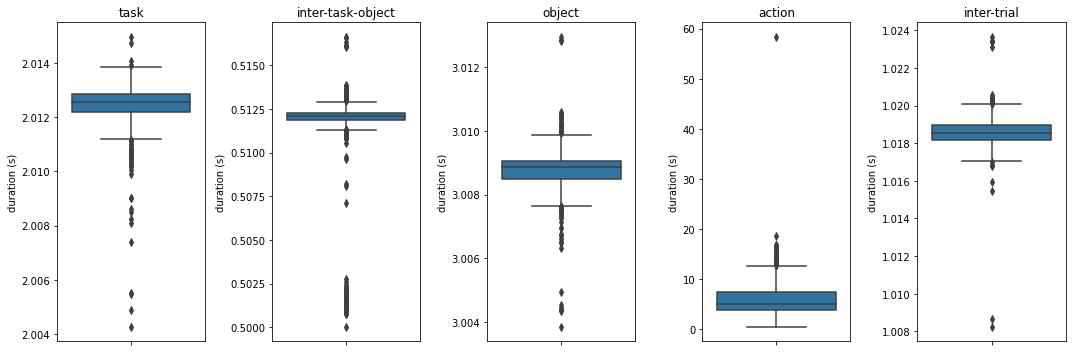

In [34]:
def inspect_events(df):
    #inspect the consistency of the triggers
    #evntlist = {desc:idx for idx, desc in event_map.items()}
    fig, ax = plt.subplots(1,len(event_mapping),figsize=(15,5),sharex=True)

    for idx,i in enumerate(event_mapping.keys()):
        print("Summary: {}".format(i))
        print("\tmean: {:6.4f}".format(df[i].mean()))
        print("\tmedian: {:6.4f}".format(df[i].median()))
        print("\tstd div: {:6.4f}".format(df[i].std()))
        sns.boxplot(y=df.loc[pd.notna(df[i]),i],ax=ax[idx])
        ax[idx].set_title("{}".format(i))
        ax[idx].set_ylabel("duration (s)")

    plt.tight_layout()
    plt.show()
    
    return

inspect_events(subj_df)

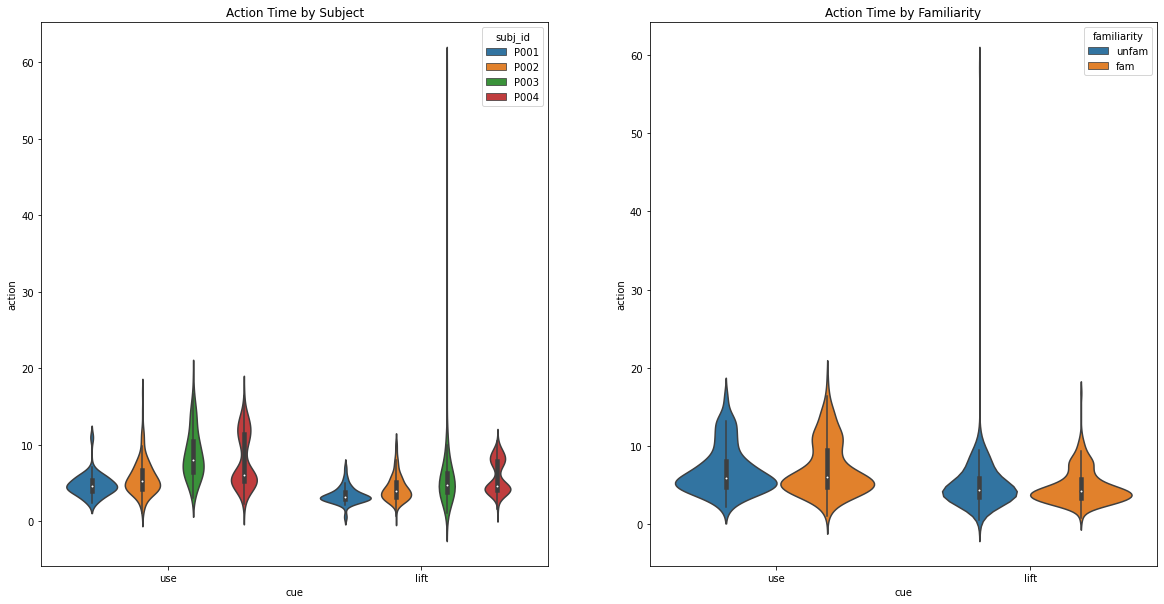

In [36]:
#plot the action timings under various conditions
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.violinplot(data=subj_df[pd.notna(subj_df)],y='action',x='cue',hue='subj_id',ax=ax[0])
ax[0].set_title("Action Time by Subject")
sns.violinplot(data=subj_df[pd.notna(subj_df)],y='action',x='cue',hue='familiarity',ax=ax[1])
ax[1].set_title("Action Time by Familiarity")
plt.show()


In [10]:
subj_df

,trial_id,block,tool,cue,ori,familiarity,subj_id,task,inter-task-object,object,action,inter-trial,condition
0,0,1,flowercutter,use,right,unfam,P001,2.005518,0.512057,3.007945,4.242989,1.018492,use/unfam/right
1,1,1,screwdriver,lift,right,fam,P001,2.012002,0.512393,3.008735,5.676056,1.019285,lift/fam/right
2,2,1,paletteknife,use,left,unfam,P001,2.013716,0.511481,3.007724,5.709325,1.018833,use/unfam/left
3,3,1,flowercutter,use,left,unfam,P001,2.012894,0.510555,3.009587,7.063972,1.018229,use/unfam/left
4,4,1,wrench,use,left,fam,P001,2.013749,0.512550,3.008674,10.738863,1.019229,use/fam/left
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,6,fork,use,left,fam,P004,2.012794,0.512276,3.007810,4.010530,1.018175,use/fam/left
236,236,6,spatula,use,right,fam,P004,2.013285,0.511219,3.008695,6.020505,1.018894,use/fam/right
237,237,6,zester,use,right,unfam,P004,2.012631,0.512131,3.007892,4.077287,1.018581,use/unfam/right
238,238,6,zester,use,left,unfam,P004,2.008252,0.516023,3.009101,4.498148,1.018961,use/unfam/left
